 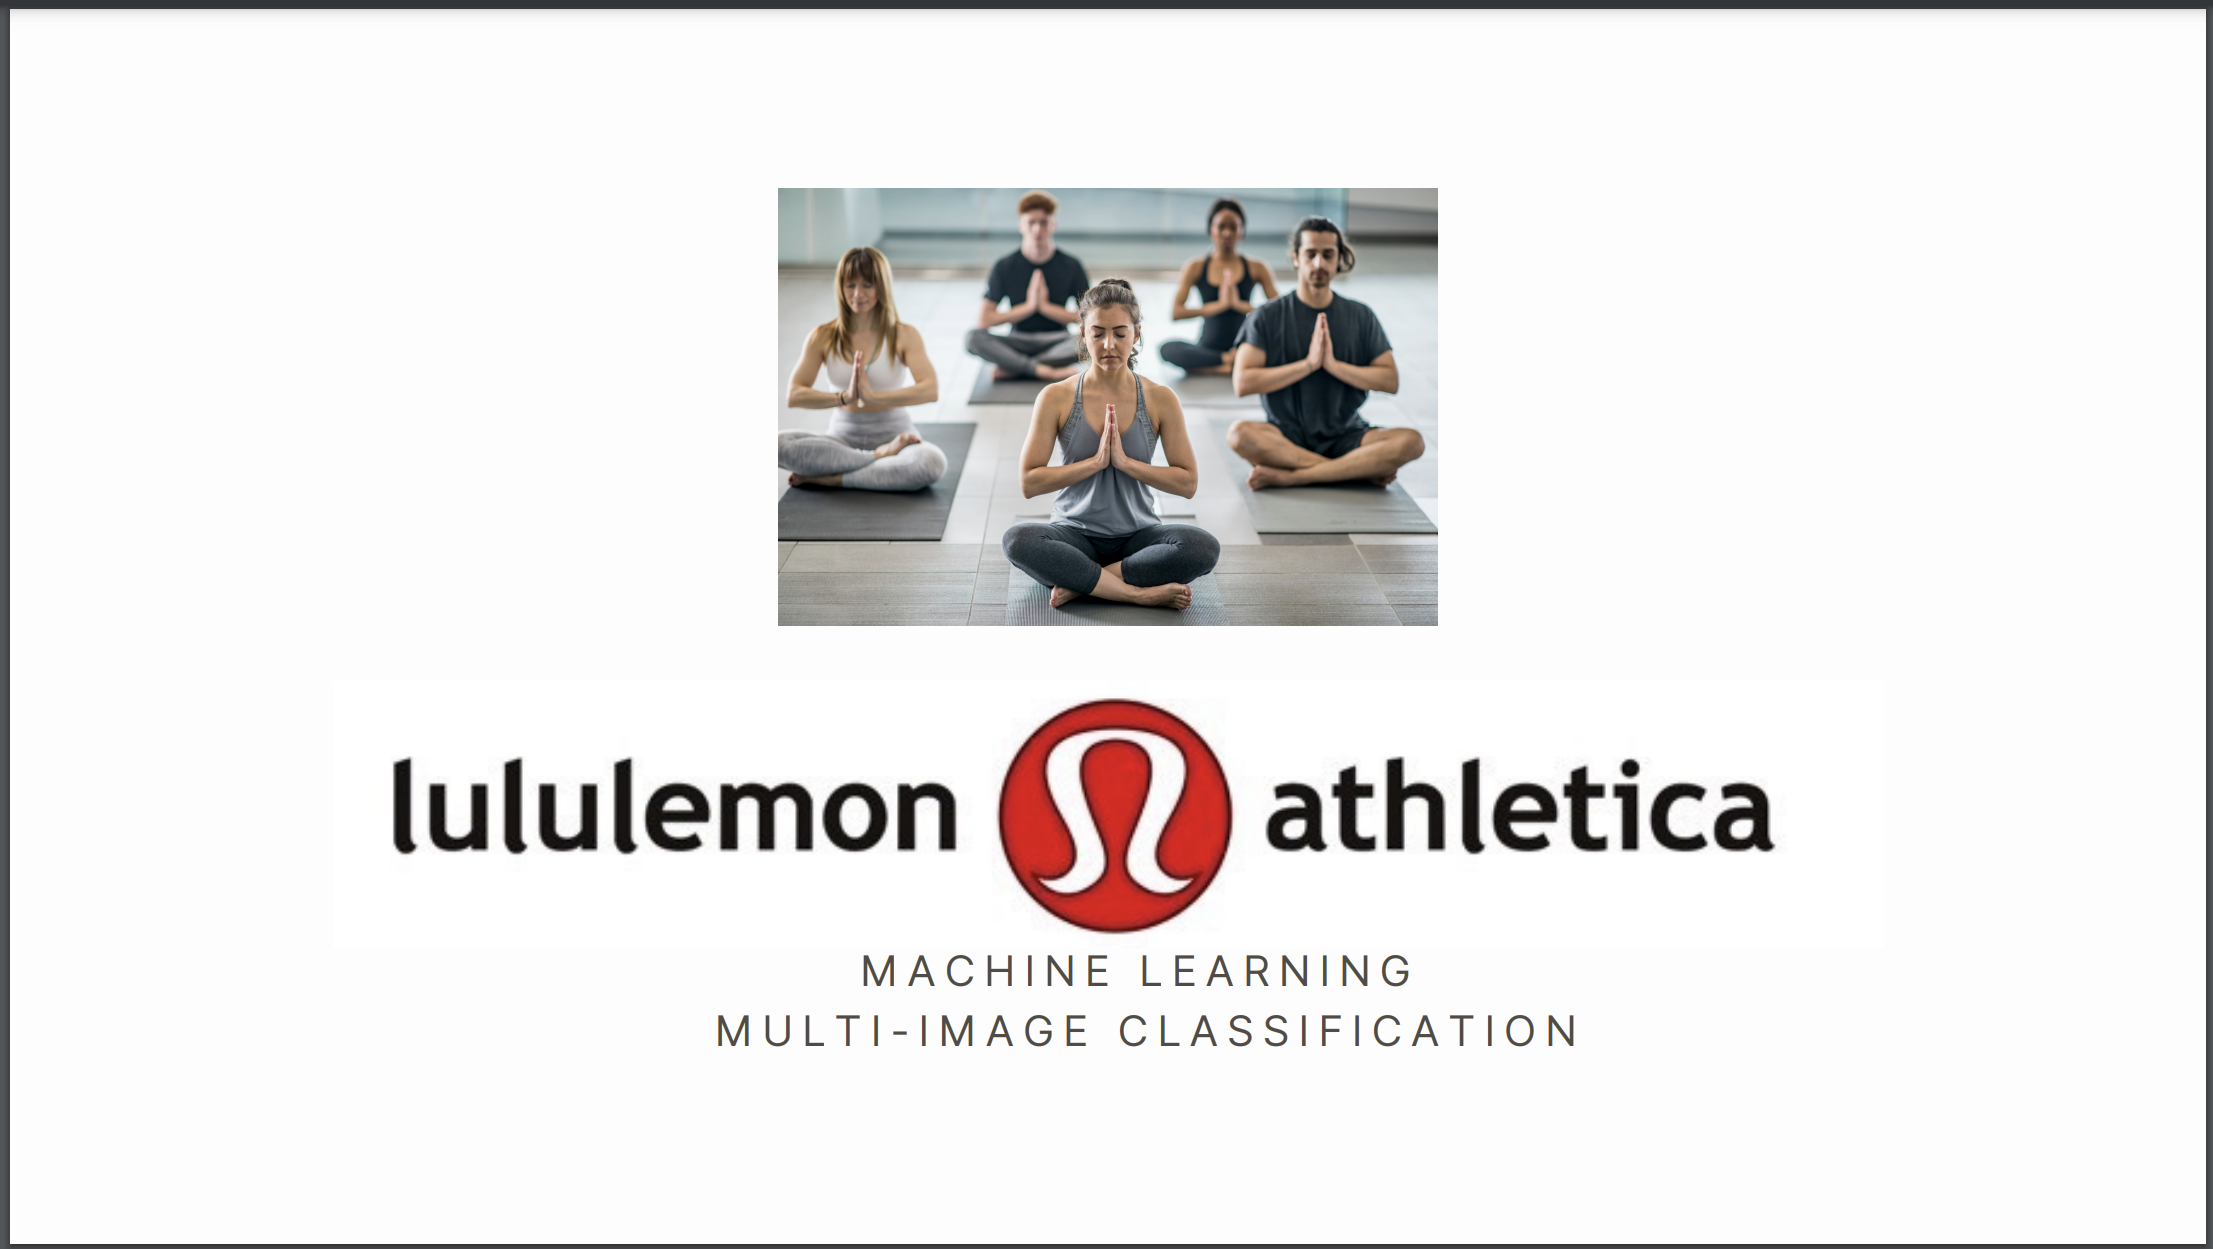

### Author: Edward Juarez

# Introduction

For this capstone project, I worked with a hypothetical client Chief Brand officer and the Lululemon marketing department. They're launching an aggressive global marketing campaign on all social media platforms promoting and attracting new customers that may feel intimidated to start practicing yoga in they’re studio or in general incentivising a reward system for any individual submitting photos of themselves with five specific yoga poses that Lululemon requires. This will also provide clarity to someone that has limited to no knowledge of yoga poses. They can also provide examples of how a pose is done from other peoples images creating a social network. They can also use this data as customer engagement. Providing accuracy, if they are doing the poses correctly or not. They are expecting an enormous feed back that would reqiure alot of time and employee efficiency.

## Business Objective

 Our goal is to create a multi image classification model by using artificial intelligence algorithms, a multi-layer Convolutional Neural Network that can identify five different yoga poses  these poses are downward dog ,tree pose, plank pose, goddess pose and the warrior two pose. The model output from this project can be used to identify yoga poses and gain reliable data.

## Data Understanding

The data used was from Kaggle a yoga pose data set. That consist of 1550 images with Rgb color values with an alpha channel which specifies the opacity for a color. We analyze 1550 still images from 5 image classes to create a multi-image classification model that would help their marketing department correctly identify image classes. With our analysis and modeling.

## Data Preparation


In this jupyter notebook, I'll be taking a set of images and training different machine learning models on them to try and create a model that is better than the baseline model accuracy. To start off this process I will import the necessary packages.

In [7]:
import numpy as np
import pandas as pd
import os
import cv2                      #pip install opencv-python
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import keras
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
from keras.layers import Dense
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, SGD
from keras.datasets import mnist
from tensorflow.keras import models, layers, optimizers, losses, metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score 
from sklearn.dummy import DummyClassifier
import datetime

original_start = datetime.datetime.now()
start = datetime.datetime.now()
#from sklearn.metrics import confusion_matrix


# Function for visualization training results


Having this function will allow us to inspect the model's performance and see if we detect any Underfitting or Overfitting it will also help adjust Hyperparameters, visualize metrics and show model progress.

In [8]:


def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_recall'], label = 'Validation Recall')
    plt.plot(history['recall'], label = 'Train Recall')
    plt.title('Recall Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show();
    


## Loading & Splitting the Data 


- The dataset, the validation data was very small in number i.e. Therefore, we did a 80-20 split on the train dataset to use an alternative set of images for validation.
- Rescale=1./255 will convert the pixels in range [0,255] to range [0,1]. This process is also called Normalizing the input. Scaling every images to the same range [0,1] will make images contributes more evenly to the total loss.

In [9]:
#Let’s initialize Keras’ ImageDataGenerator class
train_datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1./255)
#train-set
train_generator = train_datagen.flow_from_directory(
         "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='training')
#validation-set
validation_generator = train_datagen.flow_from_directory(
        "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='validation')


Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.


## Test Set

The testing data set is used after the training is done. The training and test data are compared to check that the final model works correctly. With machine learning, data is commonly split into three or more sets. With three sets, the additional set is the validation set, which is used to change learning process parameters.



In [10]:

yoga_test = test_datagen.flow_from_directory("DATASET/TEST",
        target_size=(150, 150),
        color_mode='rgba',                                     
        batch_size=32,
        class_mode='categorical',
        shuffle=False                                     
        )
                                            
                                            

Found 470 images belonging to 5 classes.


# Data Augmentation

 Data augmentation is typically always a necessary step when using a small dataset as this one. If you haven't already, implement a data augmentation setup. Our first models were created using the initial generated datasets, after training of these models we then realized we would need to perform data augmentation in order to produce quality results. We conduct a variety of augmentations utlizing the ImageDataGenerator. Augmentation was only performed on the train_set, again withholding 20% for the validation set. This augmented data set was then used to train subsequent models in our final netowrk.



# ImageDataGenerator1

In [42]:
train_datagen_aug = ImageDataGenerator(
         zoom_range=0.2, # zoom
         width_shift_range=0.2,
         height_shift_range=0.2,
         horizontal_flip=True,# horizontal flip
         vertical_flip=True,
         rotation_range=40,
         shear_range=0.2,
         rescale=1./255, validation_split=0.20)

train_generator_aug = train_datagen_aug.flow_from_directory(
          "DATASET/TRAIN",
         target_size=(150, 150),
         color_mode='rgba',
         batch_size=32,
         class_mode='categorical',
         subset='training',
         seed=7)

validation_datagen_aug = ImageDataGenerator(
         rescale=1./255, validation_split=0.20)

validation_generator_aug = validation_datagen_aug.flow_from_directory(
         "DATASET/TRAIN",
         target_size=(150, 150),
         color_mode='rgba',
         batch_size=32,
         class_mode='categorical',
         subset='validation',
         seed=7)


Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.


In [11]:
#create the datasets for future use if necessary
train_images, train_labels = next(train_generator)
test_images, test_labels = next(validation_generator)


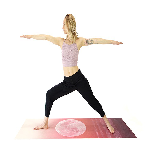

In [13]:
#exploring and inspecting some images 
array_to_img(train_images[30])


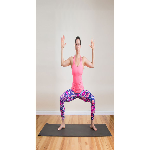

In [15]:
array_to_img(train_images[15])


In [12]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))


(32, 150, 150, 4)
(32, 5)
(32, 150, 150, 4)
(32, 5)


In [13]:
# Reshape the train images 
train_img_unrow = train_images.reshape(32, -1).T
# Preview the shape of train_img_unrow
np.shape(train_img_unrow)


(90000, 32)

In [14]:
# Define appropriate m 
m = 32
test_img_unrow = test_images.reshape(m, -1).T


In [15]:
# Preview the shape of test_img_unrow
np.shape(test_img_unrow)


(90000, 32)

In [20]:
train_generator.class_indices


{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

In [21]:
validation_generator.class_indices


{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

In [22]:
#index 0(the first column)represents no_image, index 1 represents image
train_labels_final = train_labels.T[[1]]
np.shape(train_labels_final)


(1, 32)

In [23]:
test_labels_final = test_labels.T[[1]]
np.shape(train_labels_final)


(1, 32)

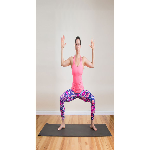

In [25]:
#sanity check look at an image and the corresponding label
array_to_img(train_images[15])


In [26]:
train_labels_final[:0]


array([], shape=(0, 32), dtype=float32)

In [27]:
# Now standardize the data standardize and/or center your dataset. 
# For images, a common thing that is done is to make sure each pixel value is between 0 and 1.
# This can be done by dividing the entire matrix by 255
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255

type(test_img_unrow)

numpy.ndarray

In [28]:
y_train = keras.utils.to_categorical(train_img_unrow, 10)
y_test = keras.utils.to_categorical(test_img_unrow, 10) 


In [301]:
y_train[0]


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 

In [29]:
y_test[0]


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 

In [30]:
yoga_test = test_datagen.flow_from_directory("DATASET/TEST",
        target_size=(150, 150),
        color_mode='rgba',                                     
        batch_size=32,
        class_mode='categorical',
        shuffle=False                                     
        )
                                            
                                            

Found 470 images belonging to 5 classes.


## Creating a Baseline Model

In [43]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(150, 150, 4)), 
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])


## Optimizer

An optimizer is a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. Thus, it helps in reducing the overall loss and improve the accuracy. The learning rate is set to default. If the learning rate is very large we will skip the optimal solution. If it is too small we will need too many iterations to converge to the best values. So using a good learning rate is crucial.


In [44]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])




## Model Summary

In [45]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 90000)             0         
                                                                 
 dense_10 (Dense)            (None, 150)               13500150  
                                                                 
 dense_11 (Dense)            (None, 5)                 755       
                                                                 
Total params: 13,500,905
Trainable params: 13,500,905
Non-trainable params: 0
_________________________________________________________________


- Reminder training deep networks is resource intensive: depending on the size of the data, even a CNN with 3-4 successive convolutional and pooling layers is appropiate to take a hours to train on a high end laptops. Using several epochs and several layers (alternating between convolutional and pooling), our model took about 15-30 minutes to run on new Macbook air

- If you are concerned with runtime, you may want to set your model to run the training epochs overnight. If you are setting up your model to run over night make sure your settings are on disable from sleeping. 

# Baseline Model


In [46]:

yoga_md1 = model.fit(train_generator_aug, epochs = 20, validation_data = validation_generator_aug)



Epoch 1/20


2023-01-13 04:29:31.237856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 46.4930 - accuracy: 0.1917 - recall: 0.1905 - auc: 0.4924 - prc: 0.1956

2023-01-13 04:29:41.925118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 13s 438ms/step - loss: 46.4930 - accuracy: 0.1917 - recall: 0.1905 - auc: 0.4924 - prc: 0.1956 - val_loss: 20.5542 - val_accuracy: 0.2419 - val_recall: 0.2419 - val_auc: 0.5171 - val_prc: 0.2349
Epoch 2/20
28/28 [==============================] - 12s 418ms/step - loss: 10.6839 - accuracy: 0.1928 - recall: 0.1894 - auc: 0.4878 - prc: 0.1967 - val_loss: 8.4436 - val_accuracy: 0.1488 - val_recall: 0.1488 - val_auc: 0.4454 - val_prc: 0.1742
Epoch 3/20
28/28 [==============================] - 12s 425ms/step - loss: 8.0690 - accuracy: 0.2125 - recall: 0.2044 - auc: 0.4983 - prc: 0.2008 - val_loss: 10.0992 - val_accuracy: 0.1767 - val_recall: 0.1767 - val_auc: 0.4664 - val_prc: 0.2110
Epoch 4/20
28/28 [==============================] - 12s 434ms/step - loss: 8.1668 - accuracy: 0.2079 - recall: 0.2021 - auc: 0.5096 - prc: 0.2091 - val_loss: 4.6504 - val_accuracy: 0.1721 - val_recall: 0.1535 - val_auc: 0.5457 - val_prc: 0.2263
Epoch 5/20
28/28 [=========

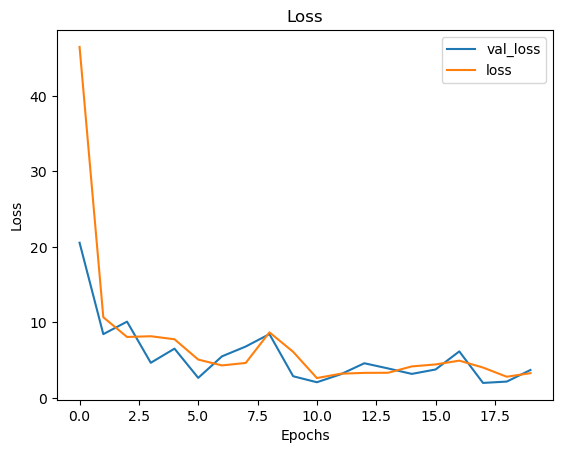

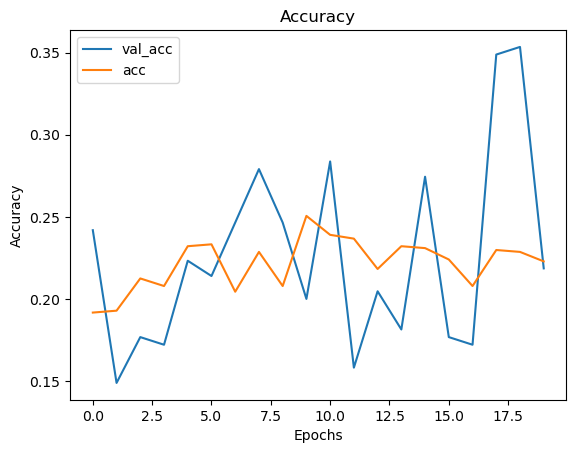

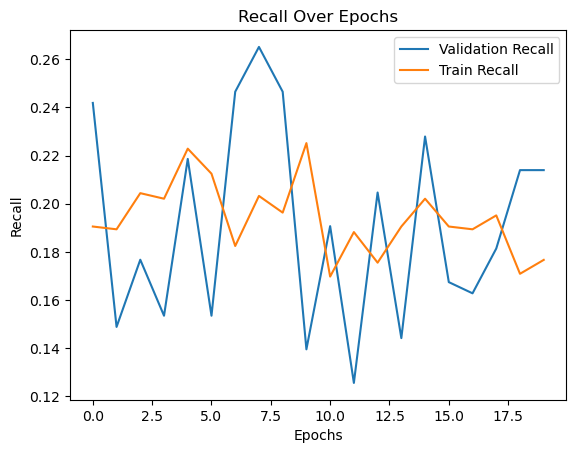

In [47]:
visualize_training_results(yoga_md1)


## Convolutional Neural Network Model

After running a baseline model I will slowly add layers to increase my val_accuracy score. I begin by running a second model and add Conv2d, Max pooling. Designing a CNN using Keras alternate convolutional and pooling layers. Adding these layers will increase larger number of parameters helping to detect more abstract patterns. Adding Drop out layers if needed will help prevent overfitting.

# Model 2
- Adding a few layers such as Conv2D,MaxPooling2,dropout,and leaving flatten to default set

In [161]:
# adding a few layers such as Conv2D,MaxPooling2,dropout,and leaving flatten to default settings
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])


In [162]:
optimizer = Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), metrics.AUC(name='prc', curve='PR')])


model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 360000)            0         
                                                                 
 dropout_12 (Dropout)        (None, 360000)            0         
                                                                 
 dense_22 (Dense)            (None, 150)               54000150  
                                                                 
 dense_23 (Dense)            (None, 5)                 755       
                                                     

In [163]:
yoga_md2  = model2.fit(train_generator, epochs = 30, validation_data = validation_generator)


Epoch 1/30


2022-12-21 18:56:33.933940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 15.6617 - accuracy: 0.2321 - recall: 0.1328 - auc: 0.5245 - prc: 0.2205

2022-12-21 18:56:45.847666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 14s 443ms/step - loss: 15.6617 - accuracy: 0.2321 - recall: 0.1328 - auc: 0.5245 - prc: 0.2205 - val_loss: 1.5898 - val_accuracy: 0.3209 - val_recall: 0.0233 - val_auc: 0.6359 - val_prc: 0.3031
Epoch 2/30
28/28 [==============================] - 12s 412ms/step - loss: 1.4372 - accuracy: 0.4711 - recall: 0.0554 - auc: 0.7319 - prc: 0.4267 - val_loss: 1.3834 - val_accuracy: 0.4186 - val_recall: 0.0651 - val_auc: 0.7435 - val_prc: 0.4547
Epoch 3/30
28/28 [==============================] - 12s 423ms/step - loss: 1.1527 - accuracy: 0.5993 - recall: 0.2471 - auc: 0.8450 - prc: 0.6411 - val_loss: 1.3580 - val_accuracy: 0.4279 - val_recall: 0.1721 - val_auc: 0.7579 - val_prc: 0.4751
Epoch 4/30
28/28 [==============================] - 12s 420ms/step - loss: 0.8917 - accuracy: 0.6998 - recall: 0.4596 - auc: 0.9127 - prc: 0.7787 - val_loss: 1.2454 - val_accuracy: 0.5209 - val_recall: 0.3581 - val_auc: 0.8092 - val_prc: 0.5353
Epoch 5/30
28/28 [============

### Accuracy score improved from .57 TO .73 
by adding Conv2D,MaxPooling2,dropout,and leaving flatten to default setting

In [157]:
model2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 360000)            0         
                                                                 
 dropout_11 (Dropout)        (None, 360000)            0         
                                                                 
 dense_20 (Dense)            (None, 150)               54000150  
                                                                 
 dense_21 (Dense)            (None, 5)                 755       
                                                     

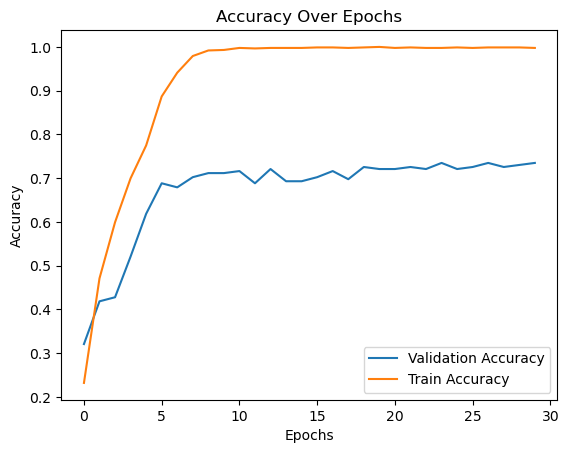

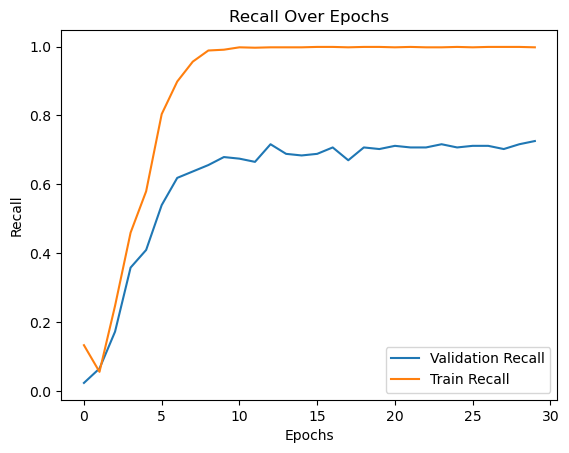

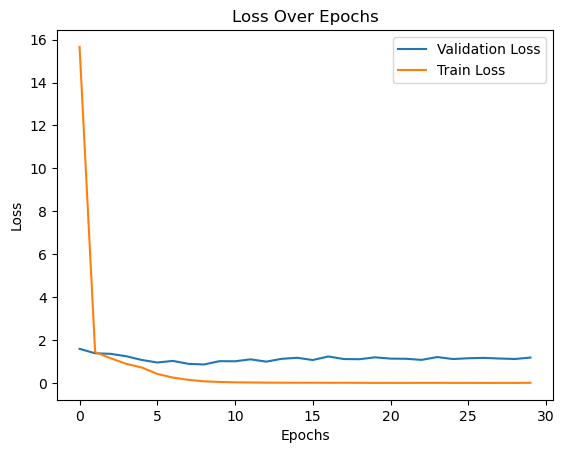

In [255]:
visualize_training_results(yoga_md2)


# Model 3 
- Adding more dense layers for better results.


In [184]:
model3 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model3.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])
epochs = 50  
batch_size = 16

model3.summary()



Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 360000)            0         
                                                                 
 dropout_18 (Dropout)        (None, 360000)            0         
                                                                 
 dense_39 (Dense)            (None, 64)                23040064  
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                     

In [185]:
yoga_md3  = model3.fit(train_generator, epochs = 30, validation_data = validation_generator)


Epoch 1/30


2022-12-22 14:26:28.146091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 8.2767 - accuracy: 0.2148 - recall: 0.1097 - auc: 0.5322 - prc: 0.2137

2022-12-22 14:26:39.289039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 13s 445ms/step - loss: 8.2767 - accuracy: 0.2148 - recall: 0.1097 - auc: 0.5322 - prc: 0.2137 - val_loss: 1.5689 - val_accuracy: 0.3209 - val_recall: 0.0000e+00 - val_auc: 0.6321 - val_prc: 0.2794
Epoch 2/30
28/28 [==============================] - 12s 411ms/step - loss: 1.4576 - accuracy: 0.4400 - recall: 0.0254 - auc: 0.7320 - prc: 0.4079 - val_loss: 1.4161 - val_accuracy: 0.4419 - val_recall: 0.0465 - val_auc: 0.7343 - val_prc: 0.4273
Epoch 3/30
28/28 [==============================] - 12s 414ms/step - loss: 1.1822 - accuracy: 0.5797 - recall: 0.2240 - auc: 0.8340 - prc: 0.6168 - val_loss: 1.2319 - val_accuracy: 0.5488 - val_recall: 0.2093 - val_auc: 0.8110 - val_prc: 0.5694
Epoch 4/30
28/28 [==============================] - 12s 416ms/step - loss: 0.9130 - accuracy: 0.7055 - recall: 0.4307 - auc: 0.9094 - prc: 0.7676 - val_loss: 1.2093 - val_accuracy: 0.5628 - val_recall: 0.3256 - val_auc: 0.8298 - val_prc: 0.5855
Epoch 5/30
28/28 [=========

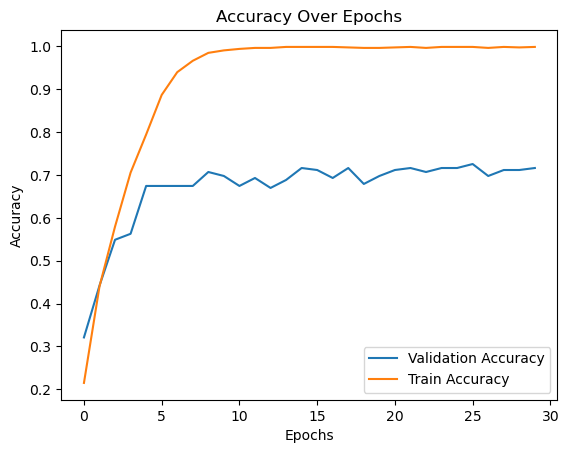

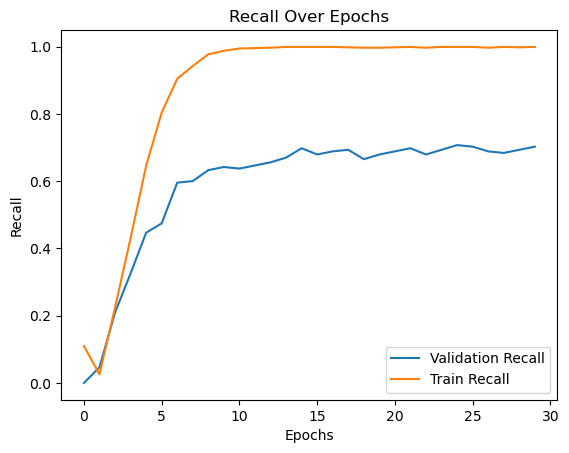

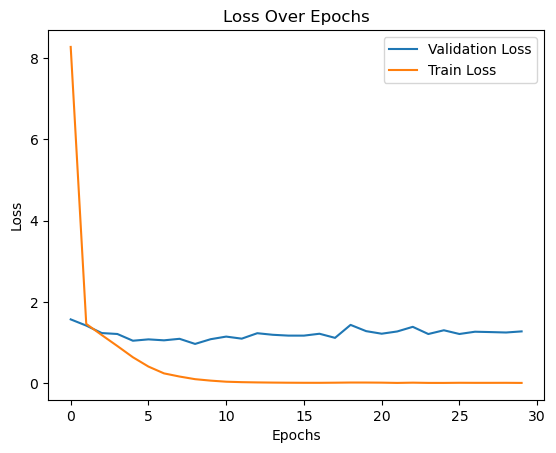

In [186]:
visualize_training_results(yoga_md3)


# Model 4

adjusted image augmentation

In [189]:

model4 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(5, activation='softmax')])

optimizer = Adam(learning_rate=0.001)
model4.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model4.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 360000)            0         
                                                                 
 dropout_21 (Dropout)        (None, 360000)            0         
                                                                 
 dense_44 (Dense)            (None, 150)               54000150  
                                                                 
 dropout_22 (Dropout)        (None, 150)               0         
                                                     

In [191]:

yoga_md4  = model4.fit(train_generator, epochs = 30, validation_data = validation_generator)


Epoch 1/30


2022-12-22 14:41:29.550843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 11.4706 - accuracy: 0.2206 - recall: 0.0855 - auc: 0.5034 - prc: 0.2055

2022-12-22 14:41:41.558422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 14s 477ms/step - loss: 11.4706 - accuracy: 0.2206 - recall: 0.0855 - auc: 0.5034 - prc: 0.2055 - val_loss: 1.6047 - val_accuracy: 0.2326 - val_recall: 0.0000e+00 - val_auc: 0.5339 - val_prc: 0.2359
Epoch 2/30
28/28 [==============================] - 13s 441ms/step - loss: 1.5960 - accuracy: 0.2402 - recall: 0.0023 - auc: 0.5628 - prc: 0.2377 - val_loss: 1.5883 - val_accuracy: 0.2698 - val_recall: 0.0000e+00 - val_auc: 0.5914 - val_prc: 0.2652
Epoch 3/30
28/28 [==============================] - 12s 428ms/step - loss: 1.5481 - accuracy: 0.2956 - recall: 0.0219 - auc: 0.6269 - prc: 0.2977 - val_loss: 1.4686 - val_accuracy: 0.3581 - val_recall: 0.0279 - val_auc: 0.7080 - val_prc: 0.3782
Epoch 4/30
28/28 [==============================] - 12s 436ms/step - loss: 1.4393 - accuracy: 0.3788 - recall: 0.0878 - auc: 0.7092 - prc: 0.4079 - val_loss: 1.3843 - val_accuracy: 0.4651 - val_recall: 0.0837 - val_auc: 0.7747 - val_prc: 0.4926
Epoch 5/30
28/28 [====

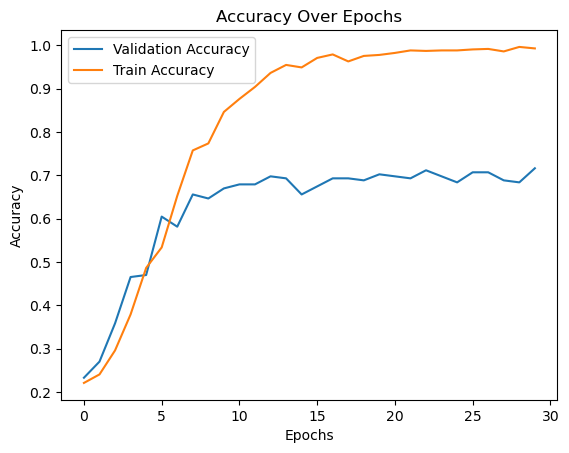

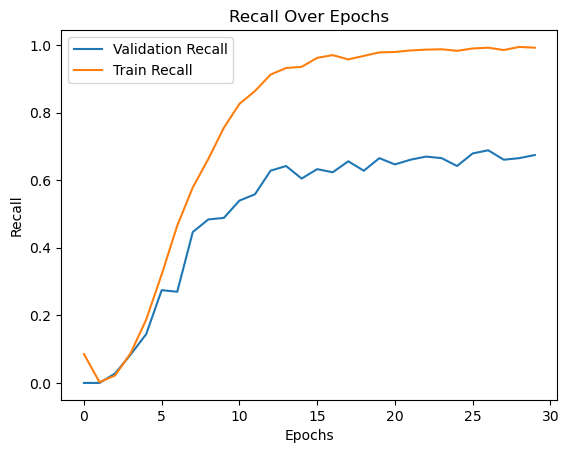

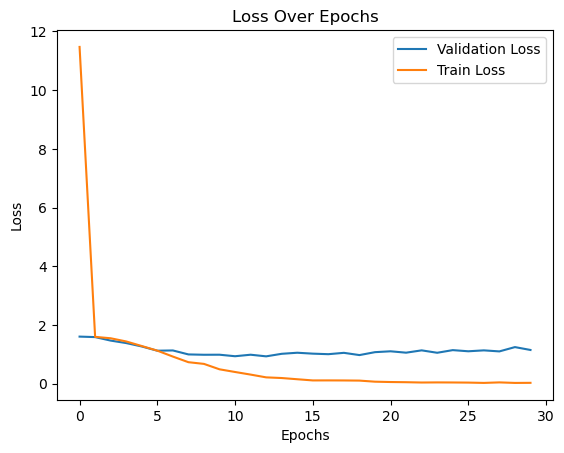

In [192]:
visualize_training_results(yoga_md4)


# Model 5
- Adjusted zoom_range=0.2, 
- Adjusted horizontal_flip=True

In [268]:
model5 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model5.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model5.summary()



Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_35 (Flatten)        (None, 360000)            0         
                                                                 
 dropout_46 (Dropout)        (None, 360000)            0         
                                                                 
 dense_78 (Dense)            (None, 150)               54000150  
                                                                 
 dropout_47 (Dropout)        (None, 150)               0         
                                                     

In [269]:
model5_results = model5.fit(train_generator_aug, epochs = 40, validation_data = validation_generator_aug)

Epoch 1/40


2022-12-22 22:40:02.382653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 13.4499 - accuracy: 0.1952 - recall: 0.1016 - auc: 0.5032 - prc: 0.2005

2022-12-22 22:40:17.010606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 18s 584ms/step - loss: 13.4499 - accuracy: 0.1952 - recall: 0.1016 - auc: 0.5032 - prc: 0.2005 - val_loss: 1.6011 - val_accuracy: 0.2372 - val_recall: 0.0000e+00 - val_auc: 0.5710 - val_prc: 0.2374
Epoch 2/40
28/28 [==============================] - 15s 531ms/step - loss: 1.6186 - accuracy: 0.2402 - recall: 0.0035 - auc: 0.5291 - prc: 0.2191 - val_loss: 1.5993 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5756 - val_prc: 0.2265
Epoch 3/40
28/28 [==============================] - 16s 548ms/step - loss: 1.5985 - accuracy: 0.2413 - recall: 0.0023 - auc: 0.5836 - prc: 0.2479 - val_loss: 1.5947 - val_accuracy: 0.2512 - val_recall: 0.0000e+00 - val_auc: 0.5733 - val_prc: 0.2297
Epoch 4/40
28/28 [==============================] - 15s 508ms/step - loss: 1.5955 - accuracy: 0.2471 - recall: 0.0035 - auc: 0.5658 - prc: 0.2382 - val_loss: 1.5860 - val_accuracy: 0.2837 - val_recall: 0.0047 - val_auc: 0.5835 - val_prc: 0.2408
Epoch 5/40
28/28 [

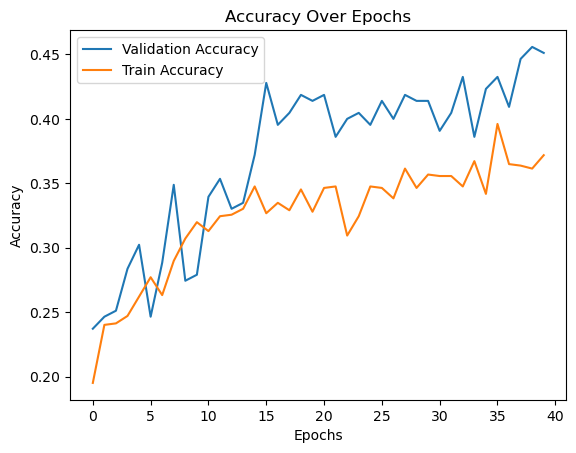

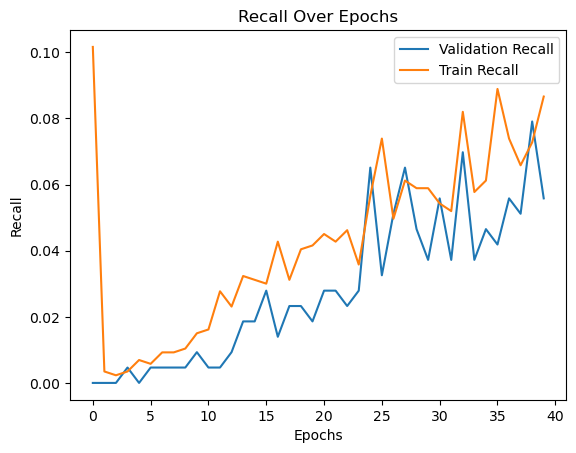

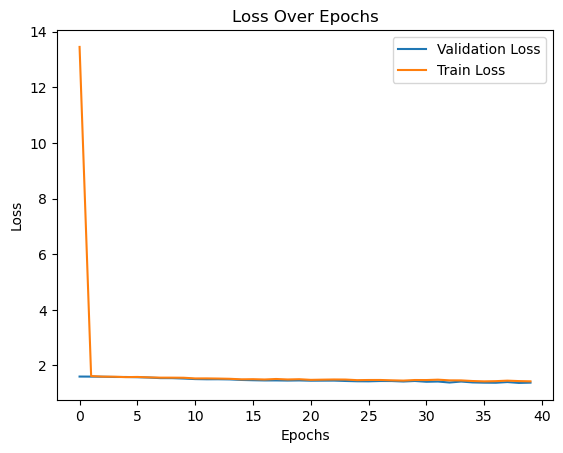

In [270]:
#add the 2 augmentation
#zoom_range=0.2, # zoom
#horizontal_flip=True,# horizontal flip
#added vertical_flip=True,

visualize_training_results(model5_results)


# Model 6
- Taking out one of the dropout .50
- Added vertical flip

In [280]:

model6 = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model6.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model6.summary()



Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 flatten_36 (Flatten)        (None, 360000)            0         
                                                                 
 dense_80 (Dense)            (None, 150)               54000150  
                                                                 
 dropout_48 (Dropout)        (None, 150)               0         
                                                                 
 dense_81 (Dense)            (None, 5)                 755       
                                                     

In [281]:
# added vertical flip to model5 Architecture and increased the epochs to 40 added rotation
model6_results = model6.fit(train_generator_aug, epochs = 40, validation_data = validation_generator_aug)

Epoch 1/40


2022-12-22 23:10:47.689753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 12.7512 - accuracy: 0.2182 - recall: 0.1166 - auc: 0.5070 - prc: 0.2038

2022-12-22 23:11:00.403897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 498ms/step - loss: 12.7512 - accuracy: 0.2182 - recall: 0.1166 - auc: 0.5070 - prc: 0.2038 - val_loss: 1.5755 - val_accuracy: 0.3116 - val_recall: 0.0047 - val_auc: 0.6440 - val_prc: 0.3113
Epoch 2/40
28/28 [==============================] - 14s 473ms/step - loss: 1.6156 - accuracy: 0.2818 - recall: 0.0035 - auc: 0.5778 - prc: 0.2523 - val_loss: 1.5653 - val_accuracy: 0.3907 - val_recall: 0.0000e+00 - val_auc: 0.7081 - val_prc: 0.3726
Epoch 3/40
28/28 [==============================] - 14s 482ms/step - loss: 1.5801 - accuracy: 0.2921 - recall: 0.0012 - auc: 0.6104 - prc: 0.2673 - val_loss: 1.5329 - val_accuracy: 0.3767 - val_recall: 0.0047 - val_auc: 0.6853 - val_prc: 0.3368
Epoch 4/40
28/28 [==============================] - 13s 469ms/step - loss: 1.5487 - accuracy: 0.3129 - recall: 0.0058 - auc: 0.6419 - prc: 0.2925 - val_loss: 1.5082 - val_accuracy: 0.3349 - val_recall: 0.0000e+00 - val_auc: 0.7052 - val_prc: 0.3284
Epoch 5/40
28/28 [====

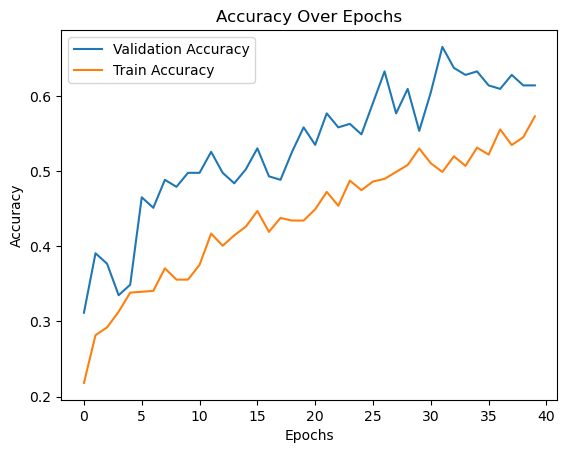

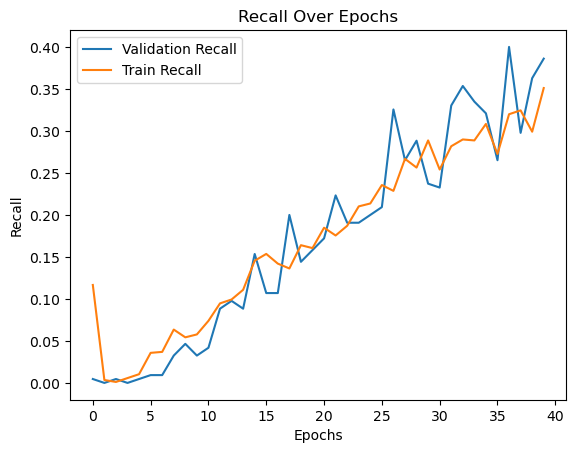

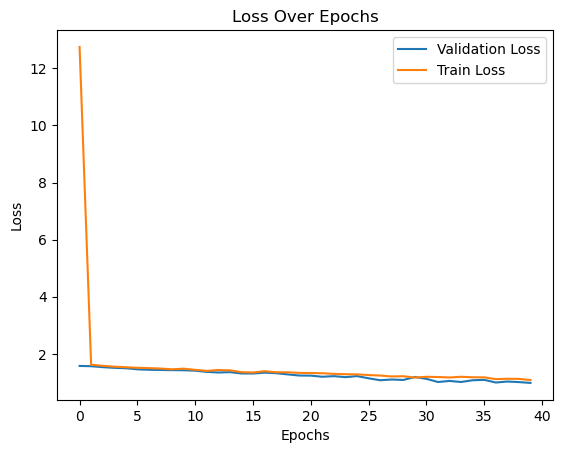

In [282]:
# zoom_range=0.2, # zoom
# horizontal_flip=True,
# model5 added vertical flip I still need to train the moodel will add aditional augmentation
# added rotation_range=40 to model 6 
visualize_training_results(model6_results)

Taking out the Dropout layer. Seems like there is to much regularization so will run with out drop out layers, Reason was my validation acuracy was higher than training accuracy 

# Model 7

In [353]:
model7= tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding ='Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), padding='Same', activation='relu'),#
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model7.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model7.summary()



Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 flatten_49 (Flatten)        (None, 180000)            0         
                                                                 
 dense_106 (Dense)           (None, 150)               27000150  
                                                                 
 dense_107 (Dense)           (None, 5)                 755       
                                                     

In [ ]:
 """
        zoom_range=0.2, # zoom
        #width_shift_range=0.2,
        ##height_shift_range=0.0,
        #horizontal_flip=True,# horizontal flip
        #vertical_flip=True,
        #rotation_range=40,
        #shear_range=0.2,
        rescale=1./255, validation_split=0.20)
        
        how model7 was set up got rid of dropout and data seems to be doing better 
        still has room for improvements 
"""

In [354]:
model7_results = model7.fit(train_generator_aug, epochs = 40, validation_data = validation_generator_aug)

Epoch 1/40


2022-12-23 13:54:59.640316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 2.8979 - accuracy: 0.2841 - recall: 0.0312 - auc: 0.5738 - prc: 0.2462

2022-12-23 13:55:11.752206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 492ms/step - loss: 2.8979 - accuracy: 0.2841 - recall: 0.0312 - auc: 0.5738 - prc: 0.2462 - val_loss: 1.5407 - val_accuracy: 0.2977 - val_recall: 0.0047 - val_auc: 0.6444 - val_prc: 0.3279
Epoch 2/40
28/28 [==============================] - 13s 450ms/step - loss: 1.4751 - accuracy: 0.4076 - recall: 0.0624 - auc: 0.6910 - prc: 0.3762 - val_loss: 1.5142 - val_accuracy: 0.4326 - val_recall: 0.1116 - val_auc: 0.6572 - val_prc: 0.4232
Epoch 3/40
28/28 [==============================] - 13s 466ms/step - loss: 1.4024 - accuracy: 0.4249 - recall: 0.1386 - auc: 0.7382 - prc: 0.4448 - val_loss: 1.4176 - val_accuracy: 0.4047 - val_recall: 0.1070 - val_auc: 0.7348 - val_prc: 0.4295
Epoch 4/40
28/28 [==============================] - 13s 455ms/step - loss: 1.2750 - accuracy: 0.4815 - recall: 0.2390 - auc: 0.7855 - prc: 0.5305 - val_loss: 1.2988 - val_accuracy: 0.4884 - val_recall: 0.1860 - val_auc: 0.8020 - val_prc: 0.5230
Epoch 5/40
28/28 [=============

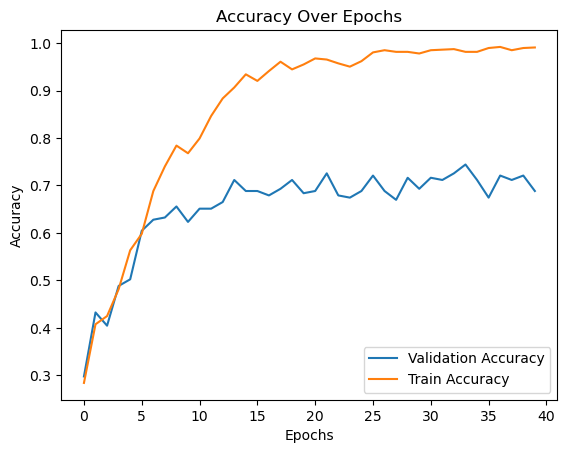

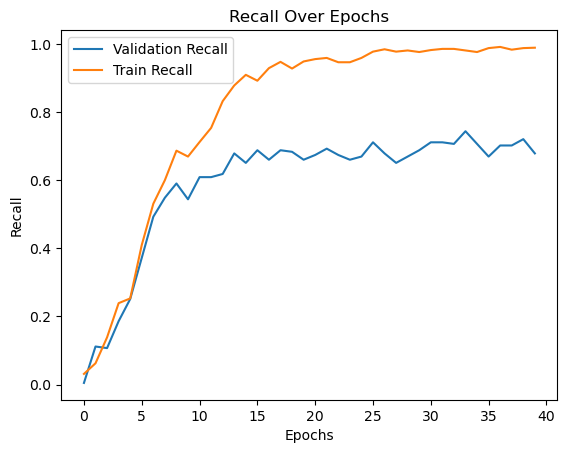

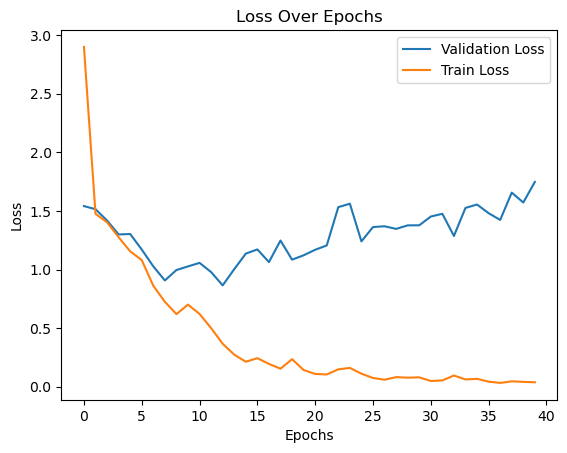

In [355]:
visualize_training_results(model7_results)


# Model 8
- Adding width_shift=.20

In [357]:
model8= tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding ='Same', input_shape=(150, 150, 4)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), padding='Same', activation='relu'),#
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model8.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


model8.summary()



Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 flatten_50 (Flatten)        (None, 180000)            0         
                                                                 
 dense_108 (Dense)           (None, 150)               27000150  
                                                                 
 dense_109 (Dense)           (None, 5)                 755       
                                                     

In [358]:

model8_results = model8.fit(train_generator_aug, epochs = 40, validation_data = validation_generator_aug)

Epoch 1/40


2022-12-23 14:14:55.265410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 3.3850 - accuracy: 0.2587 - recall: 0.0427 - auc: 0.5548 - prc: 0.2336

2022-12-23 14:15:07.621759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 486ms/step - loss: 3.3850 - accuracy: 0.2587 - recall: 0.0427 - auc: 0.5548 - prc: 0.2336 - val_loss: 1.6046 - val_accuracy: 0.3116 - val_recall: 0.0140 - val_auc: 0.6048 - val_prc: 0.2835
Epoch 2/40
28/28 [==============================] - 13s 463ms/step - loss: 1.5780 - accuracy: 0.2540 - recall: 0.0115 - auc: 0.5919 - prc: 0.2635 - val_loss: 1.5446 - val_accuracy: 0.3163 - val_recall: 0.0093 - val_auc: 0.6350 - val_prc: 0.2995
Epoch 3/40
28/28 [==============================] - 13s 462ms/step - loss: 1.5669 - accuracy: 0.3025 - recall: 0.0139 - auc: 0.6239 - prc: 0.2840 - val_loss: 1.5119 - val_accuracy: 0.2744 - val_recall: 0.0186 - val_auc: 0.6490 - val_prc: 0.3234
Epoch 4/40
28/28 [==============================] - 13s 456ms/step - loss: 1.5230 - accuracy: 0.3279 - recall: 0.0577 - auc: 0.6663 - prc: 0.3314 - val_loss: 1.4820 - val_accuracy: 0.3860 - val_recall: 0.0093 - val_auc: 0.7156 - val_prc: 0.4210
Epoch 5/40
28/28 [=============

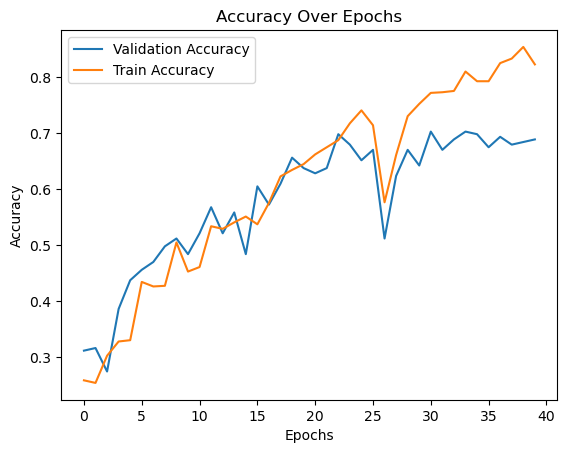

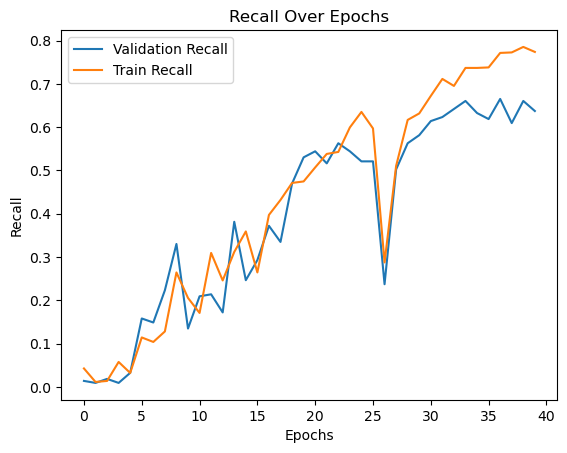

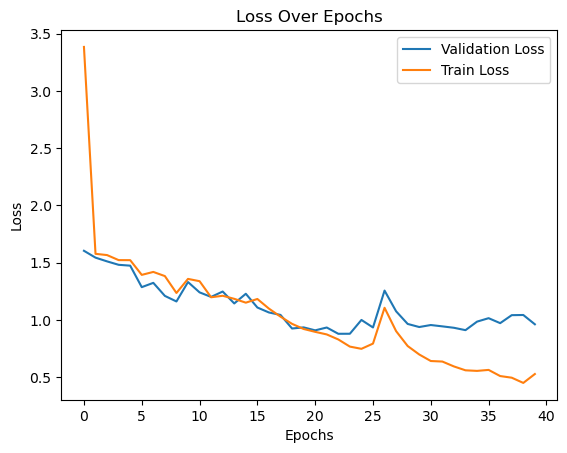

In [359]:
visualize_training_results(model8_results)


## Dropout
 So realizing the dropout has worked training data still has more training to go, with out over fitting now I'll adjust more augmentation to my data and see if we can get a bit higher validation score Id like to arrive at or above .85
I'll adjust more augmentation to my data and see if we can get a bit higher validation score Id like to get at or above .85



# Re-running Model 8 as mod_8
Seems after several image augmentations, adding and subtracting of dense layers along with dropout layers. I'll focus on this model and raise the epochs to 100 

In [394]:
mod_8= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Conv2D(32, 3, padding='Same', activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(150, activation='relu'),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_8.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_8.summary()

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 75, 75, 32)        18464     
                                                                 
 flatten_57 (Flatten)        (None, 180000)            0         
                                                                 
 dense_122 (Dense)           (None, 150)               27000150  
                                                                 
 dense_123 (Dense)           (None, 5)                 755       
                                                     

In [395]:
mod_8_results = mod_8.fit(train_generator_aug, epochs = 100, validation_data = validation_generator_aug)

Epoch 1/100


2022-12-23 19:08:30.535820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 3.8116 - accuracy: 0.2102 - recall: 0.0393 - auc: 0.5037 - prc: 0.2062

2022-12-23 19:08:43.402566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 22s 491ms/step - loss: 3.8116 - accuracy: 0.2102 - recall: 0.0393 - auc: 0.5037 - prc: 0.2062 - val_loss: 1.6079 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5509 - val_prc: 0.2270
Epoch 2/100
28/28 [==============================] - 13s 460ms/step - loss: 1.6047 - accuracy: 0.2298 - recall: 0.0035 - auc: 0.5654 - prc: 0.2386 - val_loss: 1.6049 - val_accuracy: 0.2837 - val_recall: 0.0000e+00 - val_auc: 0.5720 - val_prc: 0.2424
Epoch 3/100
28/28 [==============================] - 13s 472ms/step - loss: 1.5975 - accuracy: 0.2506 - recall: 0.0035 - auc: 0.5553 - prc: 0.2328 - val_loss: 1.5918 - val_accuracy: 0.2419 - val_recall: 0.0000e+00 - val_auc: 0.5897 - val_prc: 0.2708
Epoch 4/100
28/28 [==============================] - 13s 458ms/step - loss: 1.6330 - accuracy: 0.2494 - recall: 0.0092 - auc: 0.5590 - prc: 0.2321 - val_loss: 1.5970 - val_accuracy: 0.2372 - val_recall: 0.0000e+00 - val_auc: 0.5715 - val_prc: 0.2439
Epoch 5/100


28/28 [==============================] - 14s 504ms/step - loss: 0.3224 - accuracy: 0.8926 - recall: 0.8580 - auc: 0.9862 - prc: 0.9556 - val_loss: 0.9953 - val_accuracy: 0.7116 - val_recall: 0.6930 - val_auc: 0.9105 - val_prc: 0.7684
Epoch 68/100
28/28 [==============================] - 14s 490ms/step - loss: 0.3015 - accuracy: 0.9018 - recall: 0.8730 - auc: 0.9875 - prc: 0.9626 - val_loss: 1.1380 - val_accuracy: 0.7070 - val_recall: 0.6884 - val_auc: 0.9087 - val_prc: 0.7684
Epoch 69/100
28/28 [==============================] - 14s 479ms/step - loss: 0.2711 - accuracy: 0.9249 - recall: 0.8926 - auc: 0.9898 - prc: 0.9706 - val_loss: 1.0116 - val_accuracy: 0.7349 - val_recall: 0.7163 - val_auc: 0.9153 - val_prc: 0.7873
Epoch 70/100
28/28 [==============================] - 14s 483ms/step - loss: 0.2768 - accuracy: 0.9065 - recall: 0.8799 - auc: 0.9903 - prc: 0.9697 - val_loss: 1.0413 - val_accuracy: 0.7116 - val_recall: 0.7070 - val_auc: 0.9111 - val_prc: 0.7737
Epoch 71/100
28/28 [=====

In [48]:
visualize_training_results(model_8_results)


NameError: name 'model_8_results' is not defined

## Models (9,10,11) ran on ImageDataGenerator2

# ImageDataGenerator2

In [56]:
train_datagen_aug2 = ImageDataGenerator(
        #zoom_range=0.2, # zoom
        width_shift_range=0.15,
        #height_shift_range=0.2,
        horizontal_flip=True,# horizontal flip
        #vertical_flip=True,
        #rotation_range=40,
        #shear_range=0.2,
        rescale=1./255, validation_split=0.20)

train_generator_aug2 = train_datagen_aug.flow_from_directory(
         "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='training',
        seed=7)

validation_datagen_aug2 = ImageDataGenerator(
        rescale=1./255, validation_split=0.20)

validation_generator_aug2 = validation_datagen_aug.flow_from_directory(
        "DATASET/TRAIN",
        target_size=(150, 150),
        color_mode='rgba',
        batch_size=32,
        class_mode='categorical',
        subset='validation',
        seed=7)


Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.


# Model 9
Ran this model witdth_shift .20

In [516]:

mod_x= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(256, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(1024, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_x.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_x.summary()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_142 (Conv2D)         (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_115 (MaxPooli  (None, 75, 75, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_81 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 conv2d_143 (Conv2D)         (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_116 (MaxPooli  (None, 37, 37, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_82 (Dropout)        (None, 37, 37, 128)     

In [476]:
mod_x_results = mod_x.fit(train_generator_aug2, epochs = 50, validation_data = validation_generator_aug2)

Epoch 1/50


2022-12-29 17:25:33.199604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 3.5544 - accuracy: 0.2587 - recall: 0.0289 - auc: 0.5360 - prc: 0.2228

2022-12-29 17:25:50.838724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 21s 637ms/step - loss: 3.5544 - accuracy: 0.2587 - recall: 0.0289 - auc: 0.5360 - prc: 0.2228 - val_loss: 1.5989 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5629 - val_prc: 0.2363
Epoch 2/50
28/28 [==============================] - 16s 565ms/step - loss: 1.5956 - accuracy: 0.2564 - recall: 0.0000e+00 - auc: 0.5609 - prc: 0.2285 - val_loss: 1.5918 - val_accuracy: 0.2605 - val_recall: 0.0000e+00 - val_auc: 0.5884 - val_prc: 0.2369
Epoch 3/50
28/28 [==============================] - 16s 576ms/step - loss: 1.5844 - accuracy: 0.2898 - recall: 0.0000e+00 - auc: 0.5951 - prc: 0.2483 - val_loss: 1.5459 - val_accuracy: 0.4651 - val_recall: 0.0000e+00 - val_auc: 0.6695 - val_prc: 0.3105
Epoch 4/50
28/28 [==============================] - 16s 563ms/step - loss: 1.5785 - accuracy: 0.3187 - recall: 0.0023 - auc: 0.6347 - prc: 0.2704 - val_loss: 1.5755 - val_accuracy: 0.3349 - val_recall: 0.0000e+00 - val_auc: 0.6251 - val_prc: 0.2731
Epoch 5

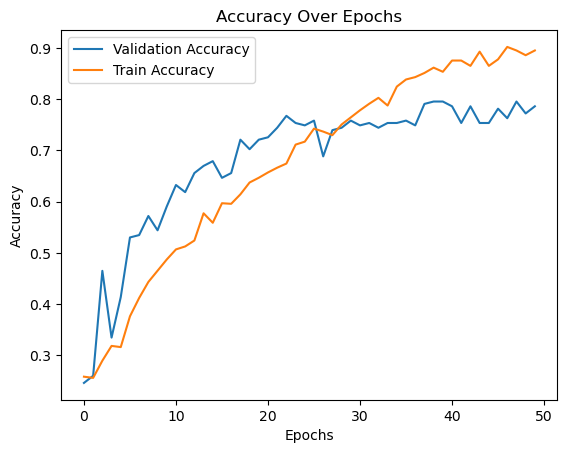

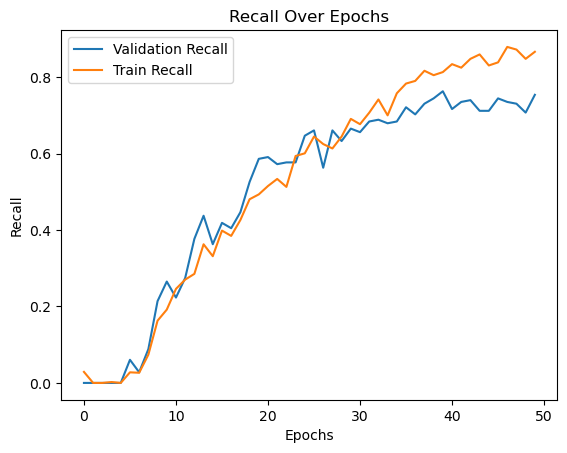

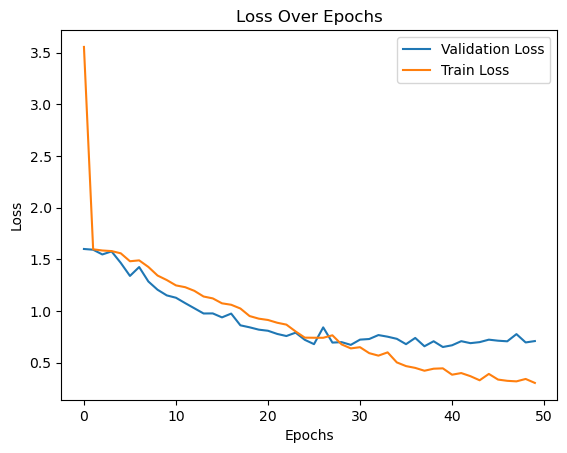

In [477]:
visualize_training_results(mod_x_results)


# Model 10
Adjusted width_shift to .10

In [518]:
# this adjusted width_shift to .10
mod_x1= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(256, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(1024, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_x1.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_x1.summary()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_146 (Conv2D)         (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 75, 75, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_86 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 conv2d_147 (Conv2D)         (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 37, 37, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_87 (Dropout)        (None, 37, 37, 128)     

In [519]:
mod_x1_results = mod_x1.fit(train_generator_aug2, epochs = 50, validation_data = validation_generator_aug2)

Epoch 1/50


2023-01-03 15:12:51.791084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 1.9624 - accuracy: 0.2483 - recall: 0.0208 - auc: 0.5334 - prc: 0.2222

2023-01-03 15:13:05.527759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 16s 534ms/step - loss: 1.9624 - accuracy: 0.2483 - recall: 0.0208 - auc: 0.5334 - prc: 0.2222 - val_loss: 1.6048 - val_accuracy: 0.2326 - val_recall: 0.0000e+00 - val_auc: 0.5583 - val_prc: 0.2289
Epoch 2/50
28/28 [==============================] - 14s 478ms/step - loss: 1.5954 - accuracy: 0.2413 - recall: 0.0000e+00 - auc: 0.5622 - prc: 0.2278 - val_loss: 1.5910 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5825 - val_prc: 0.2367
Epoch 3/50
28/28 [==============================] - 14s 481ms/step - loss: 1.5775 - accuracy: 0.3060 - recall: 0.0000e+00 - auc: 0.6102 - prc: 0.2575 - val_loss: 1.5224 - val_accuracy: 0.4558 - val_recall: 0.0000e+00 - val_auc: 0.7164 - val_prc: 0.3728
Epoch 4/50
28/28 [==============================] - 14s 494ms/step - loss: 1.4922 - accuracy: 0.3857 - recall: 0.0208 - auc: 0.6900 - prc: 0.3423 - val_loss: 1.3112 - val_accuracy: 0.5349 - val_recall: 0.0930 - val_auc: 0.7915 - val_prc: 0.5385
Epoch 5/50


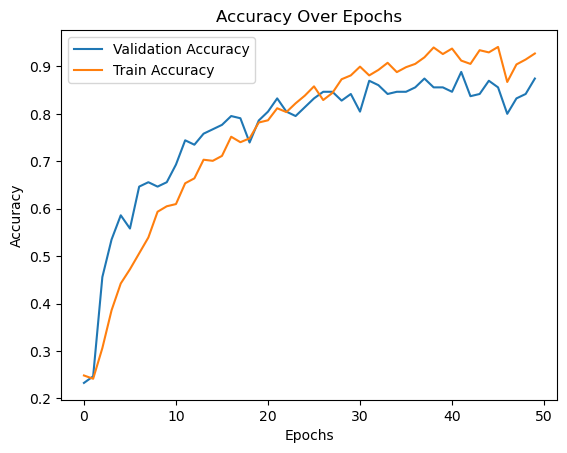

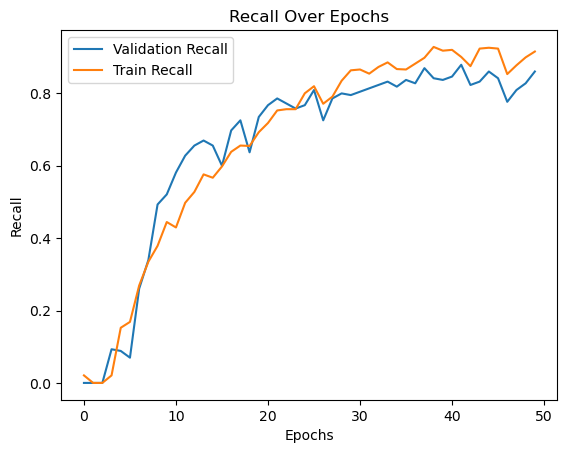

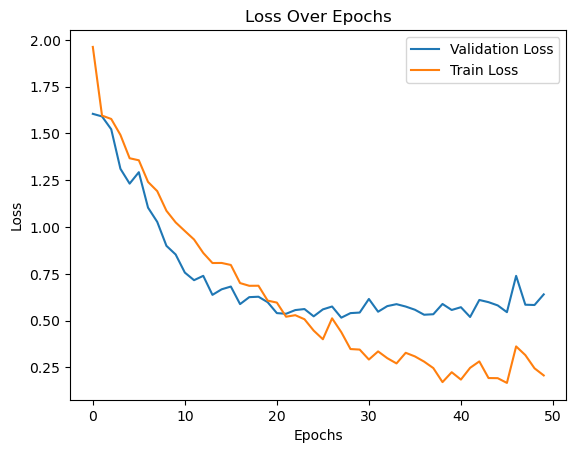

In [520]:
visualize_training_results(mod_x1_results)


# Final Model
## Model 11

Slighly changed the range on width_shift to .15 instead of .10 trying to bring down the training score  and lift the val score seems like im hitting a wall with the validation score.I like the way the model has performed could use more time to keep tuning but this set up will do.


In [57]:
mod_x2= tf.keras.models.Sequential([
       tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding = 'Same', input_shape=(150, 150, 4)),
       tf.keras.layers.MaxPooling2D(2, 2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding = 'Same'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(128, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Conv2D(256, 3, padding='Same', activation='relu'),
       tf.keras.layers.MaxPooling2D(2,2),
       tf.keras.layers.Dropout(0.25),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(1024, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
mod_x2.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy', metrics.Recall(name='recall'), metrics.AUC(name='auc'), 
                       metrics.AUC(name='prc', curve='PR')])


mod_x2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 64)      2368      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 37, 37, 128)      

In [58]:
mod_x2_results = mod_x2.fit(train_generator_aug2, epochs = 200, validation_data = validation_generator_aug2)

Epoch 1/200


2023-01-04 17:15:02.050579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 2.0379 - accuracy: 0.2263 - recall: 0.0162 - auc: 0.5294 - prc: 0.2158

2023-01-04 17:15:15.226500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 15s 505ms/step - loss: 2.0379 - accuracy: 0.2263 - recall: 0.0162 - auc: 0.5294 - prc: 0.2158 - val_loss: 1.5995 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5668 - val_prc: 0.2293
Epoch 2/200
28/28 [==============================] - 14s 505ms/step - loss: 1.5956 - accuracy: 0.2344 - recall: 0.0000e+00 - auc: 0.5596 - prc: 0.2293 - val_loss: 1.6024 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5752 - val_prc: 0.2374
Epoch 3/200
28/28 [==============================] - 14s 507ms/step - loss: 1.5963 - accuracy: 0.2667 - recall: 0.0000e+00 - auc: 0.5720 - prc: 0.2383 - val_loss: 1.5951 - val_accuracy: 0.2465 - val_recall: 0.0000e+00 - val_auc: 0.5967 - val_prc: 0.2523
Epoch 4/200
28/28 [==============================] - 17s 580ms/step - loss: 1.5775 - accuracy: 0.2725 - recall: 0.0012 - auc: 0.6012 - prc: 0.2540 - val_loss: 1.5281 - val_accuracy: 0.4419 - val_recall: 0.0000e+00 - val_auc: 0.6747 - val_prc: 0.3483
Epoc

28/28 [==============================] - 18s 625ms/step - loss: 0.1229 - accuracy: 0.9630 - recall: 0.9561 - auc: 0.9970 - prc: 0.9905 - val_loss: 0.6931 - val_accuracy: 0.8558 - val_recall: 0.8372 - val_auc: 0.9618 - val_prc: 0.9297
Epoch 68/200
28/28 [==============================] - 20s 694ms/step - loss: 0.1404 - accuracy: 0.9492 - recall: 0.9457 - auc: 0.9969 - prc: 0.9891 - val_loss: 0.7482 - val_accuracy: 0.8419 - val_recall: 0.8372 - val_auc: 0.9588 - val_prc: 0.9100
Epoch 69/200
28/28 [==============================] - 19s 667ms/step - loss: 0.1161 - accuracy: 0.9584 - recall: 0.9573 - auc: 0.9968 - prc: 0.9919 - val_loss: 0.7765 - val_accuracy: 0.8372 - val_recall: 0.8326 - val_auc: 0.9591 - val_prc: 0.9163
Epoch 70/200
28/28 [==============================] - 17s 595ms/step - loss: 0.1156 - accuracy: 0.9654 - recall: 0.9596 - auc: 0.9964 - prc: 0.9891 - val_loss: 0.7357 - val_accuracy: 0.8279 - val_recall: 0.8233 - val_auc: 0.9646 - val_prc: 0.9268
Epoch 71/200
28/28 [=====

28/28 [==============================] - 15s 539ms/step - loss: 0.0742 - accuracy: 0.9804 - recall: 0.9804 - auc: 0.9979 - prc: 0.9939 - val_loss: 0.7193 - val_accuracy: 0.8372 - val_recall: 0.8372 - val_auc: 0.9637 - val_prc: 0.9231
Epoch 134/200
28/28 [==============================] - 15s 533ms/step - loss: 0.0585 - accuracy: 0.9861 - recall: 0.9850 - auc: 0.9983 - prc: 0.9951 - val_loss: 0.7224 - val_accuracy: 0.8372 - val_recall: 0.8326 - val_auc: 0.9643 - val_prc: 0.9163
Epoch 135/200
28/28 [==============================] - 15s 536ms/step - loss: 0.0533 - accuracy: 0.9850 - recall: 0.9850 - auc: 0.9989 - prc: 0.9968 - val_loss: 0.6878 - val_accuracy: 0.8605 - val_recall: 0.8465 - val_auc: 0.9706 - val_prc: 0.9349
Epoch 136/200
28/28 [==============================] - 15s 525ms/step - loss: 0.0521 - accuracy: 0.9827 - recall: 0.9815 - auc: 0.9982 - prc: 0.9951 - val_loss: 0.8015 - val_accuracy: 0.8698 - val_recall: 0.8651 - val_auc: 0.9549 - val_prc: 0.9167
Epoch 137/200
28/28 [=

28/28 [==============================] - 21s 751ms/step - loss: 0.0466 - accuracy: 0.9792 - recall: 0.9781 - auc: 0.9990 - prc: 0.9971 - val_loss: 0.8805 - val_accuracy: 0.8605 - val_recall: 0.8605 - val_auc: 0.9542 - val_prc: 0.9037
Epoch 200/200
28/28 [==============================] - 20s 715ms/step - loss: 0.0596 - accuracy: 0.9838 - recall: 0.9827 - auc: 0.9983 - prc: 0.9951 - val_loss: 0.9492 - val_accuracy: 0.8558 - val_recall: 0.8558 - val_auc: 0.9524 - val_prc: 0.8988


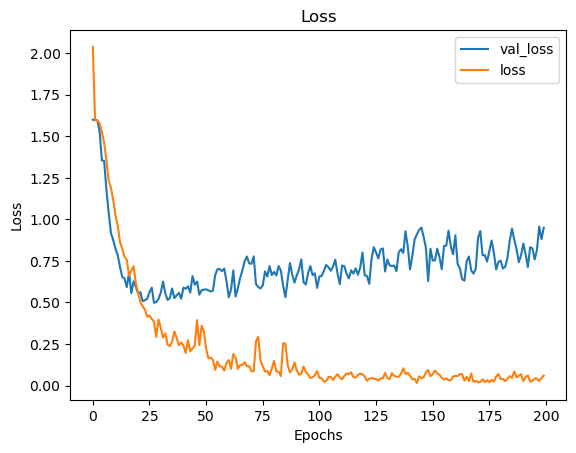

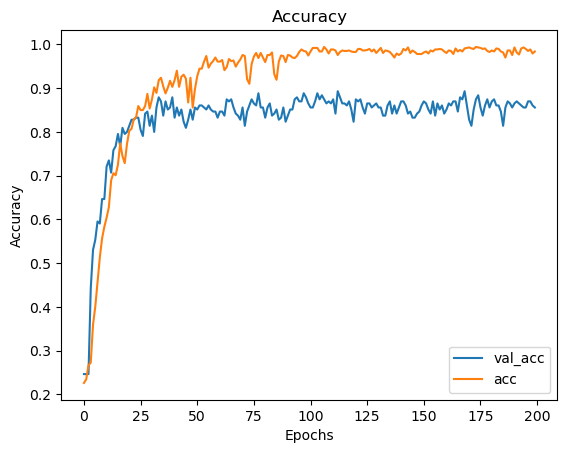

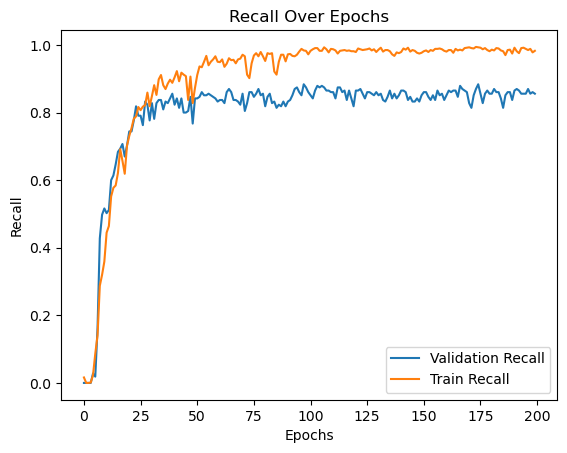

In [59]:
visualize_training_results(mod_x2_results)


# Final Evaluation
Taking the unseen test data to see how the model performs.

In [60]:
mod_x2.evaluate(yoga_test)



15/15 [==============================] - 9s 574ms/step - loss: 0.5384 - accuracy: 0.9106 - recall: 0.9085 - auc: 0.9708 - prc: 0.9389


[0.5383552312850952,
 0.9106382727622986,
 0.9085106253623962,
 0.9708007574081421,
 0.9388781785964966]

# Test Data Accuracy score = .9106

In [91]:
test_datagen = ImageDataGenerator(rescale=1./255)



In [92]:

yoga_test = test_datagen.flow_from_directory("DATASET/TEST",
        target_size=(150, 150),
        color_mode='rgba',                                     
        batch_size=32,
        class_mode='categorical',
        shuffle=False                                     
        )
                          

Found 470 images belonging to 5 classes.


In [61]:
predictions = mod_x2.predict(yoga_test)


2023-01-04 18:20:57.587080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 7s 492ms/step


In [62]:
predictions


array([[1.0000000e+00, 3.9562301e-19, 5.4943316e-16, 1.8771350e-20,
        1.3896403e-17],
       [9.9999559e-01, 3.8787482e-10, 4.3768705e-06, 1.8786405e-12,
        4.1366580e-10],
       [1.0000000e+00, 2.3806636e-30, 1.1881318e-21, 3.0788044e-36,
        1.5841964e-24],
       ...,
       [3.7747543e-07, 2.1168762e-01, 3.6698229e-09, 4.3338724e-07,
        7.8831160e-01],
       [1.2795670e-14, 1.0372236e-04, 1.9340866e-12, 1.3843836e-11,
        9.9989629e-01],
       [2.7285370e-07, 5.9396853e-03, 1.5553325e-05, 2.2065264e-07,
        9.9404436e-01]], dtype=float32)

In [63]:
y_pred = np.argmax(predictions, axis = 1)
print(len(y_pred))


470


In [64]:
y_test = yoga_test.classes
print(len(y_test))


470


# Confusion Matrix

Making a Confusion Matrix to see how our model did.
Let's start this confusion matrix off by getting the appropriate library imported and taking a look at the array. Using a confusion matrix to display how accurate or model is doing and to see what our model is incorrectly identifying Ive decided to use a sns.heatmap function.


In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [66]:
cf_matrix = confusion_matrix(y_test, y_pred)


In [67]:
cf_matrix



array([[ 91,   1,   3,   1,   1],
       [  4,  64,   4,   1,   7],
       [  3,   1, 106,   2,   3],
       [  1,   1,   1,  66,   0],
       [  0,   2,   4,   2, 101]])

In [68]:
confusion_matrix(y_test, y_pred)



array([[ 91,   1,   3,   1,   1],
       [  4,  64,   4,   1,   7],
       [  3,   1, 106,   2,   3],
       [  1,   1,   1,  66,   0],
       [  0,   2,   4,   2, 101]])

In [69]:
labels = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']


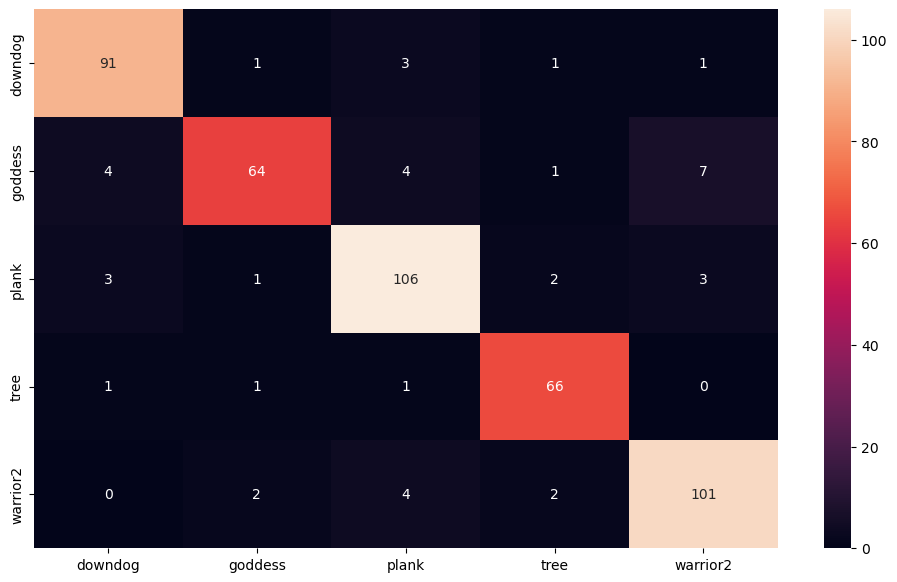

In [87]:
The_final_matrix = pd.DataFrame(cf_matrix)
plt.figure(figsize = (12,7));
sns.heatmap(cf_matrix, annot=True, fmt='', xticklabels=labels, yticklabels=labels);
plt.xticks(rotation=0)
plt.show()

In [71]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.94      0.93        97
           1       0.93      0.80      0.86        80
           2       0.90      0.92      0.91       115
           3       0.92      0.96      0.94        69
           4       0.90      0.93      0.91       109

    accuracy                           0.91       470
   macro avg       0.91      0.91      0.91       470
weighted avg       0.91      0.91      0.91       470



# Evaluation and Conclusion


Lululemon gains reliable data and can add new sales growth opportunities with this data at the same exact time it would allow us to gather up more images for future projects , such as ,segmentation leading to virtual Try on for clothing,  accessories and other items improving user experience. Other uses include face recognition which could enable current contactless payments with one's face as a proof.

# Visualizing the way some of the models preformed after adjustments.

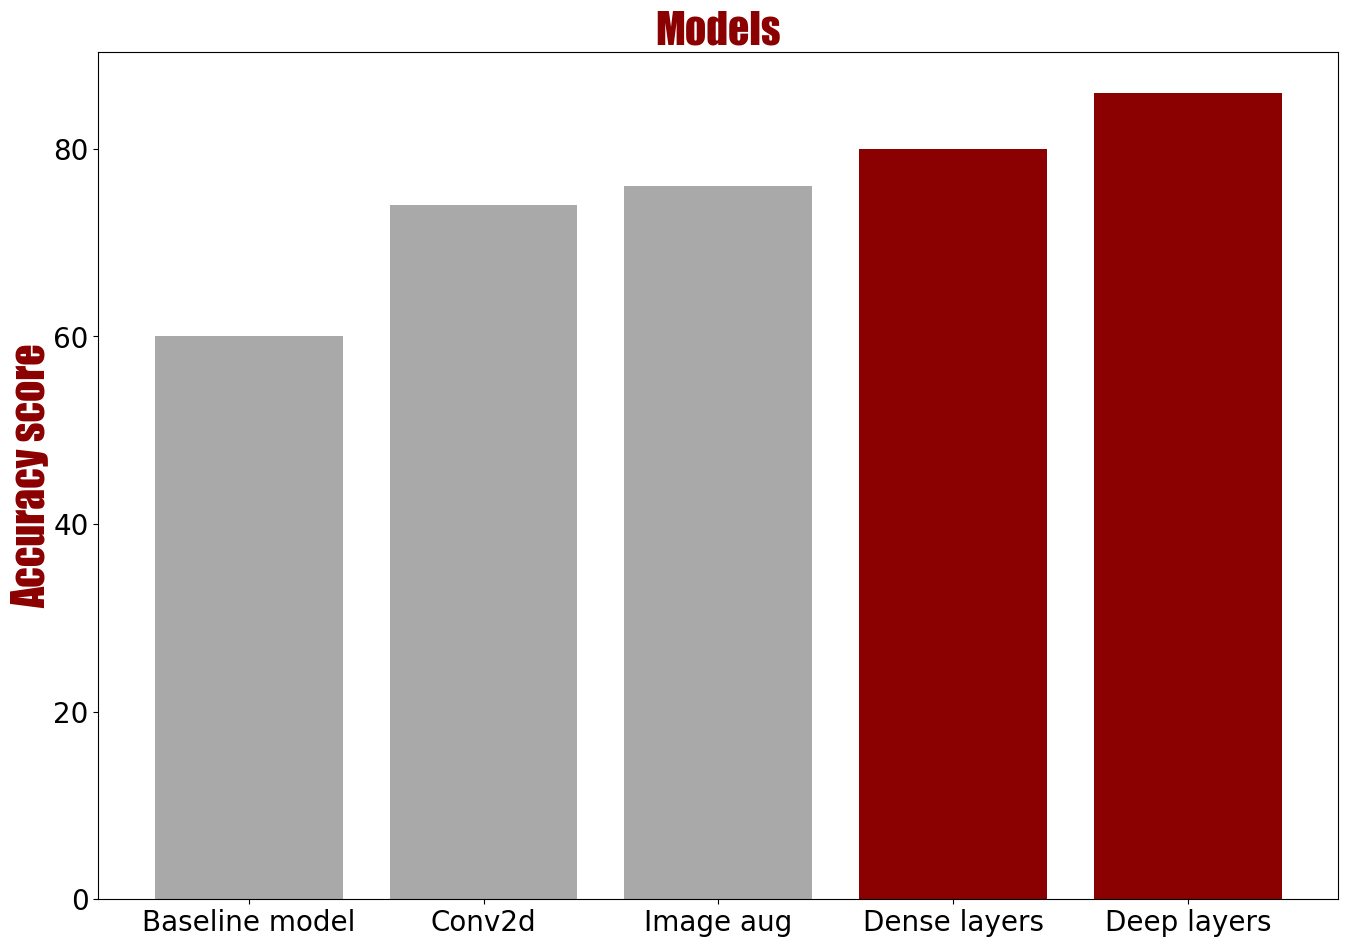

In [89]:
fig, ax = plt.subplots(figsize=(16, 11))


height = [60, 74, 76, 80, 86]

bars = ('Baseline model', 'Conv2d', 'Image aug','Dense layers', 'Deep layers')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height, color=('darkgrey', 'darkgrey','darkgrey', 'darkred', 'darkred'))


# Create names on the x-axis
plt.xticks(y_pos, bars,fontsize=20)
plt.yticks(fontsize=20)
#font properties
font1 = {'family':'fantasy','color':'darkred','size':30}

# Label x, y and title
ax.set_title('Models',fontdict= font1)
ax.set_ylabel('Accuracy score',fontdict= font1)


# Show graphic
plt.show()


# Visualizing Baseline model vs Final model

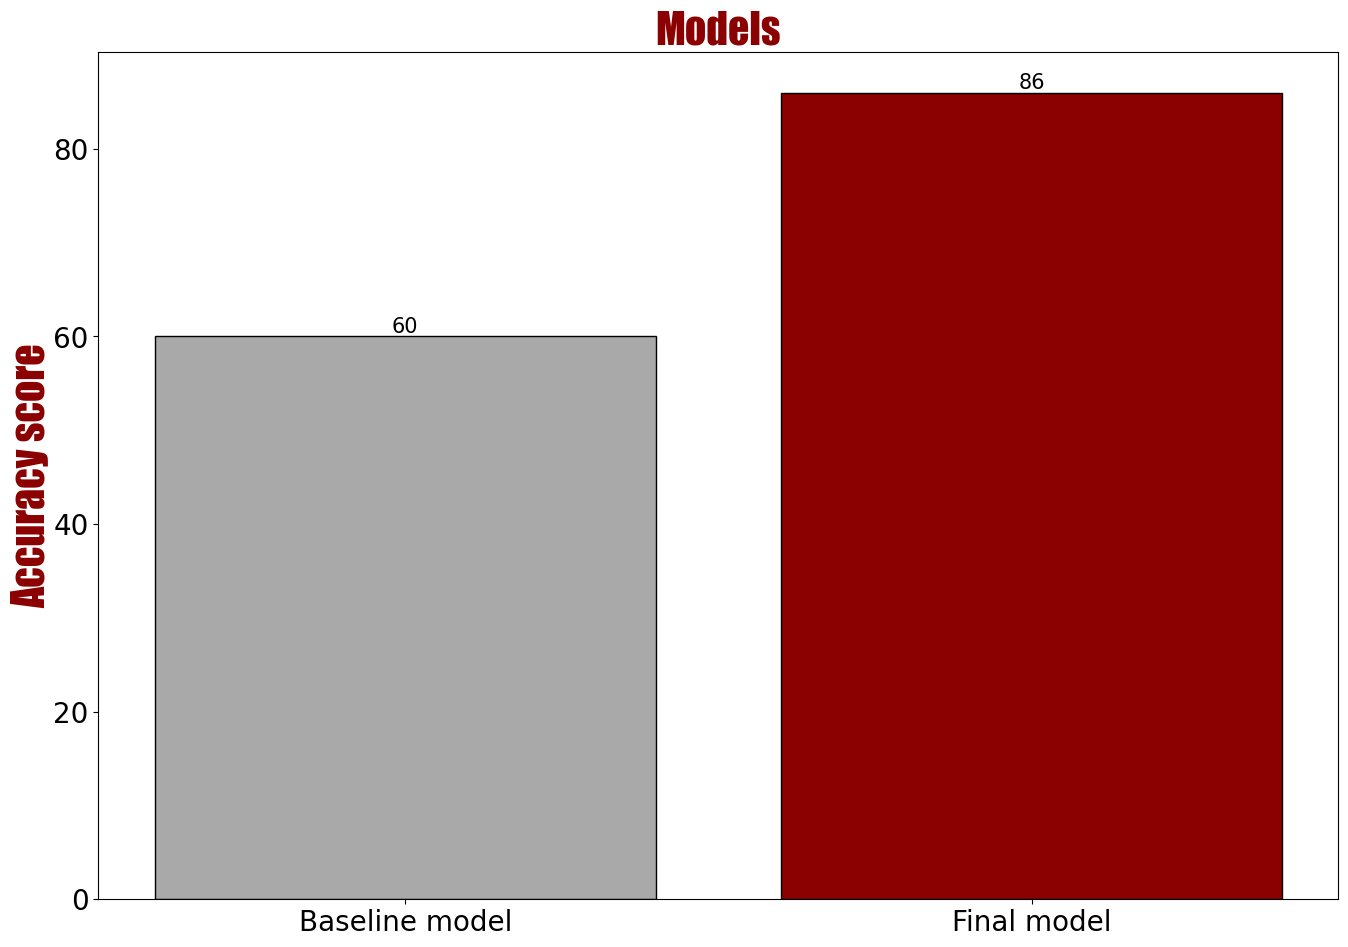

In [103]:

fig, ax = plt.subplots(figsize=(16, 11))


height = [60, 86]

bars = ('Baseline model', 'Final model')
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, height, color=('darkgrey', 'darkred'),ec="black")

for i in range(len(bars)):
    plt.text(i,height[i], height[i], ha="center", va="bottom",fontsize=15)


# Create names on the x-axis
plt.xticks(y_pos, bars,fontsize=20)
plt.yticks(fontsize=20)
          
#font properties
font1 = {'family':'fantasy','color':'darkred','size':30}

# Label x, y and title
ax.set_title('Models',fontdict= font1)
ax.set_ylabel('Accuracy score',fontdict= font1)


# Show graphic
plt.show()


